In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sacc

import os

os.environ["CLMM_MODELING_BACKEND"] = (
    "ccl"  # Need to use NumCosmo as CLMM's backend as well.
)
import clmm  # noqa: E402
from clmm import Cosmology  # noqa: E402

import math
import itertools

from numcosmo_py import Nc
from numcosmo_py import Ncm

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import pyccl as ccl


## Import Redmapper Data


In [2]:
Omb = 0.02258 / 0.71**2
Omc = 0.1109 / 0.71**2


In [3]:
def generate_sacc_file() -> Any:
    """Generate a SACC file for cluster number counts and cluster deltasigma."""
    path = "/sps/lsst/groups/clusters/cl_pipeline_project/eduardo/CLCosmo_Sim_database"
    t = np.load(
        f"{path}/data/stacked_esd_profiles_redmapper_true_full_coverage.pkl",
        allow_pickle=True,
    )
    
    n_z_bins = 7
    n_rich_bins = 4

    area = 439.78986

    
    richness_bins = np.log10(t["stacked profile"][0:n_rich_bins]["obs_bin"])
    redshift_bins = [t["stacked profile"][0 + n_rich_bins * i]["z_bin"] for i in range(n_z_bins)]

    print(list(richness_bins), redshift_bins)

    s_count = sacc.Sacc()
    bin_z_labels = []
    bin_richness_labels = []
    bin_radius_labels = []

    survey_name = "cosmodc2"
    s_count.add_tracer("survey", survey_name, area)
    z_bins = []
    rich_bins = []
    for i, z_bin in enumerate(redshift_bins):
        lower, upper = z_bin
        bin_z_label = f"bin_z_{i}"
        s_count.add_tracer("bin_z", bin_z_label, lower, upper)
        bin_z_labels.append(bin_z_label)
        z_bins.append((lower,upper))
    for i, richness_bin in enumerate(richness_bins):
        lower, upper = richness_bin
        bin_richness_label = f"rich_{i}"
        s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
        bin_richness_labels.append(bin_richness_label)
        rich_bins.append((lower,upper))

    cluster_counts = []
    for i in range(0, n_z_bins):
        for j in range(0, n_rich_bins):
            counts = t["stacked profile"][j + i * n_rich_bins]["n_stack"]
            cluster_counts.append(counts)
            s_count.add_data_point(
                sacc.standard_types.cluster_counts,
                (survey_name, bin_z_labels[i], bin_richness_labels[j]),
                int(counts),
            )

    counts_array = np.array(t["stacked profile"]["n_stack"])
    data = t['stacked covariance']['cov_t']
    cov_counts = counts_array.flatten()
    covariance = np.diag(cov_counts)


    # ### Then the add the covariance and save the file
    s_count.add_covariance(covariance)
    s_count.to_canonical_order()
    #s_count.save_fits("/pbs/home/e/ebarroso/CosmoPipeline/Theory Test/cosmodc2.sacc",overwrite=True)
    
    return  z_bins, rich_bins, s_count, n_z_bins, n_rich_bins, counts_array, covariance
    

if __name__ == "__main__":
    Ncm.cfg_init()
    z_bins, rich_bins, sac_s, nz, nr, counts, covariance = generate_sacc_file()

[array([1.30103   , 1.54406804]), array([1.54406804, 1.84509804]), array([1.84509804, 2.        ]), array([2.     , 2.30103])] [array([0.2, 0.3]), array([0.3, 0.4]), array([0.4, 0.5]), array([0.5, 0.6]), array([0.6, 0.7]), array([0.7, 0.8]), array([0.8, 1. ])]


In [4]:
s_read = sacc.Sacc.load_fits("/pbs/home/e/ebarroso/CLPipeline/cl_theory_test/cosmodc2.sacc") 
data_points = s_read.get_data_points(f"{sacc.standard_types.cluster_counts}")



## Initiating mass function and defining parameters

In [5]:
from firecrown.models.cluster.recipes.murata_binned_spec_z_selection import MurataBinnedSpecZSelectionRecipe as MDS
from firecrown.models.cluster.abundance_data import AbundanceData
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.binning import SaccBin
from firecrown.models.cluster.properties import ClusterProperty
from firecrown.likelihood.binned_cluster_number_counts import BinnedClusterNumberCounts

In [6]:
hmf = ccl.halos.MassFuncDespali16(mass_def="200c")
min_mass, max_mass = 13, 15
min_z, max_z = 0.1, 1.2
cluster_abundance = ClusterAbundance(min_mass, max_mass, min_z, max_z, hmf)
cosmo_ccl = ccl.Cosmology(
            Omega_b=0.0448, Omega_c=0.22, sigma8=0.8, w0=-1, wa=0, h=0.71, n_s=0.96
        )
sky_area = 400

## Reading data from SACC

In [7]:
DSD = AbundanceData(s_read)
survey_nm = "cosmodc2"
data_type = sacc.standard_types.cluster_counts
##CHECK THIS ONE TOO


In [8]:
## CHecking COMpleteness and purity of data

In [9]:
def f_completeness(x, a_nc, b_nc, a_mc, b_mc):
    # Ensure x is a NumPy array
    log10m, z = x[1], x[0]
    # Compute the nc and log10_mc terms based on z and log10m
    nc = a_nc + b_nc * (1.0 + z)
    log10_mc = a_mc + b_mc * (1 + z)
    # Calculate the logistic function
    exponent = nc * np.log(10) * (log10m - log10_mc )
    result = np.exp(exponent) / (1 + np.exp(exponent))
    
    return result
def f_purity_constantin(x, a_nc, b_nc, a_mc, b_mc):
    # Ensure x is a NumPy array
    log10m, z = x[1], x[0]
    # Compute the nc and log10_mc terms based on z and log10m
    nc = a_nc + b_nc * (1.0 + z)
    log10_mc = a_mc + b_mc * (1 + z)
    # Calculate the logistic function
    exponent = np.log(10**log10m) / log10_mc
    result = np.exp(exponent)**nc / (1 + np.exp(exponent)**nc)
    
    return result

In [10]:
print(f_completeness((np.array(0.15), np.log10(10)),3.9193, -0.3323, 1.1839, -0.4077))

0.9105887292063369


## Purity Test

[array([0.54860013, 0.66098848, 0.7622477 , 0.84383396, 0.90323378,
       0.9429446 , 0.97606442]), array([0.88825056, 0.93063925, 0.95870176, 0.97628447, 0.98681159,
       0.99287724, 0.99731342]), array([0.97458695, 0.98541308, 0.99186793, 0.99558915, 0.99766967,
       0.99879998, 0.99957697]), array([0.99462446, 0.99706855, 0.99844199, 0.99919262, 0.99959194,
       0.99979882, 0.99993352])]
[array([0.99761731, 0.99817746, 0.9985974 , 0.99891394, 0.99915384,
       0.99933666, 0.99953419]), array([0.99973405, 0.9997924 , 0.99983693, 0.99987111, 0.99989749,
       0.99991796, 0.99994058]), array([0.99995772, 0.99996642, 0.99997316, 0.99997841, 0.99998253,
       0.99998577, 0.99998942]), array([0.99999328, 0.99999457, 0.99999558, 0.99999638, 0.99999702,
       0.99999753, 0.99999812])]


Text(0.5, 0, 'bins')

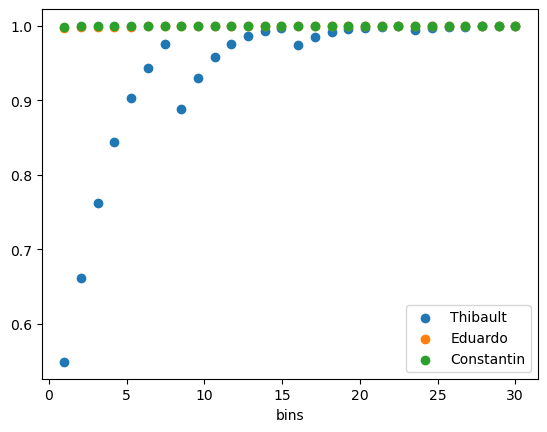

In [11]:
thibault_values_p = []
eduardo_values_p = []
constantin_values_p = []
sacc_bins = DSD.get_bin_edges(survey_nm, ClusterProperty.COUNTS)
richness_bins = [(s_bin.mass_proxy_edges) for s_bin in sacc_bins]
z_bins = [(s_bin.z_edges) for s_bin in sacc_bins]
z_bins = list(dict.fromkeys(z_bins))
richness_bins = list(dict.fromkeys(richness_bins))
zmean = [0.5 * (z_bin[1] + z_bin[0]) for z_bin in z_bins]
for j in range(len(richness_bins)):
    rmean = 0.5 * (richness_bins[j][1] + richness_bins[j][0])
    thibault_values_p.append(f_completeness((np.array(zmean), np.array(rmean)),np.log(10)*0.8612, np.log(10)*0.3527,2.2183, -0.6592))
    constantin_values_p.append(f_purity_constantin((np.array(zmean), np.array(rmean)),np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592))
    eduardo_values_p.append(f_completeness((np.array(zmean), np.array(rmean)),3.9193, -0.3323, 1.1839, -0.4077))
print(thibault_values_p)
print(eduardo_values_p)
plt.scatter(np.linspace(1,30, len(np.array(thibault_values_p).flatten())),np.array(thibault_values_p).flatten(), label='Thibault')
plt.scatter(np.linspace(1,30, len(np.array(eduardo_values_p).flatten())),np.array(eduardo_values_p).flatten(),label='Eduardo')
plt.scatter(np.linspace(1,30, len(np.array(constantin_values_p).flatten())),np.array(constantin_values_p).flatten(), label='Constantin')
plt.legend()
plt.xlabel('bins')

### Comparison between different values

In [12]:
from firecrown.models.cluster.kernel import Completeness, Purity
comp_f = Completeness()
purity_f = Purity()
purity_f.__setattr__('ap_nc', 2.0048)
purity_f.__setattr__('bp_nc', 0.8025)
purity_f.__setattr__('ap_rc', 0.978)
purity_f.__setattr__('bp_rc', -0.2957)
sacc_bins = DSD.get_bin_edges(survey_nm, ClusterProperty.COUNTS)
richness_bins = [(s_bin.mass_proxy_edges) for s_bin in sacc_bins]
z_bins = [(s_bin.z_edges) for s_bin in sacc_bins]
z_bins = list(dict.fromkeys(z_bins))
richness_bins = list(dict.fromkeys(richness_bins))
zmean = [0.5 * (z_bin[1] + z_bin[0]) for z_bin in z_bins]
for j in range(len(richness_bins)):
    rmean = 0.5 * (richness_bins[j][1] + richness_bins[j][0])
for j in range(len(richness_bins)):
    rmean = 0.5 * (richness_bins[j][1] + richness_bins[j][0])
    print(purity_f.distribution(np.array(zmean), np.array([rmean]), rmean))
    print(f_completeness((np.array(zmean), np.array(rmean)),2.0048, 0.8025, 0.978, -0.2957))

[0.99645608 0.99752659 0.99829302 0.99883502 0.9992137  0.99947512
 0.99971958]
[0.99645608 0.99752659 0.99829302 0.99883502 0.9992137  0.99947512
 0.99971958]
[0.99945983 0.9996418  0.99976506 0.99984759 0.99990221 0.99993793
 0.99996926]
[0.99945983 0.9996418  0.99976506 0.99984759 0.99990221 0.99993793
 0.99996926]
[0.99988857 0.99992916 0.99995546 0.9999723  0.99998296 0.99998963
 0.99999518]
[0.99988857 0.99992916 0.99995546 0.9999723  0.99998296 0.99998963
 0.99999518]
[0.99997702 0.999986   0.99999156 0.99999497 0.99999703 0.99999827
 0.99999924]
[0.99997702 0.999986   0.99999156 0.99999497 0.99999703 0.99999827
 0.99999924]


## Completeness Test

comp firecrown [array([0.11578937, 0.09438272, 0.07576172, 0.05990187, 0.04666561,
       0.03583209, 0.02348318]), array([0.2654423 , 0.23491686, 0.20498626, 0.17626479, 0.14930163,
       0.12454268, 0.09218842]), array([0.4992951 , 0.47495923, 0.44782659, 0.41813186, 0.38622228,
       0.35256707, 0.3001262 ]), array([0.7334567 , 0.7271596 , 0.71839299, 0.70702272, 0.69288663,
       0.6758028 , 0.64423847]), array([0.88363202, 0.88703084, 0.88918711, 0.89016059, 0.88997822,
       0.88863495, 0.88435297]), array([0.95445044, 0.95856338, 0.96189006, 0.96455885, 0.96666963,
       0.96829912, 0.96996274]), array([0.98299984, 0.98553962, 0.9875608 , 0.98917713, 0.99047493,
       0.99151993, 0.99272005]), array([0.99377191, 0.99504447, 0.99601151, 0.99675253, 0.997325  ,
       0.99777072, 0.99826642])] comp thibault [array([0.11578937, 0.09438272, 0.07576172, 0.05990187, 0.04666561,
       0.03583209, 0.02348318]), array([0.2654423 , 0.23491686, 0.20498626, 0.17626479, 0.14930163,
  

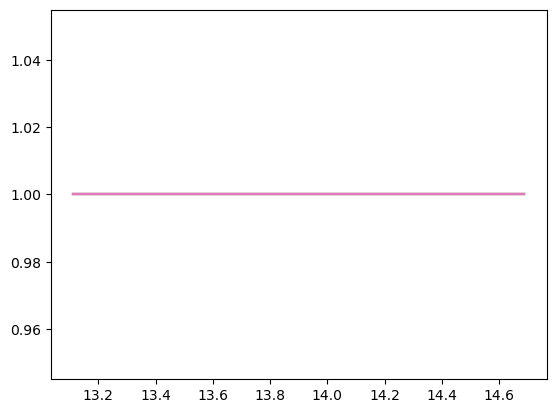

In [13]:
comp_f.__setattr__('ac_nc', 0.38)
comp_f.__setattr__('bc_nc', 1.2634)
comp_f.__setattr__('ac_mc', 13.31)
comp_f.__setattr__('bc_mc', 0.2025)
sacc_bins = DSD.get_bin_edges(survey_nm, ClusterProperty.COUNTS)
richness_bins = [(s_bin.mass_proxy_edges) for s_bin in sacc_bins]
z_bins = [(s_bin.z_edges) for s_bin in sacc_bins]
z_bins = list(dict.fromkeys(z_bins))
m_edges = np.linspace(13,14.8, 9)
mass_bins = [0.5 * (m_edges[i] + m_edges[i+1])for i in range(len(m_edges)-1)]
zmean = [0.5 * (z_bin[1] + z_bin[0]) for z_bin in z_bins]
comp_firecrown = []
comp_thibault = []
for mass_mean in mass_bins:
    comp_firecrown.append(comp_f.distribution(np.array(mass_mean), np.array(zmean)))
    comp_thibault.append(f_completeness((np.array(zmean), np.array(mass_mean)),0.38,1.2634,13.31,0.2025))
print(f'comp firecrown {comp_firecrown} comp thibault {comp_thibault}')
plt.plot(mass_bins, np.array(comp_firecrown)/np.array(comp_thibault))

### Comparison between different values

[0.10236827 0.08688817 0.0730693  0.06088877 0.05028379 0.04116004
 0.02999171 0.25216529 0.22648641 0.2015556  0.17768336 0.15514231
 0.13415513 0.10593072 0.49924716 0.47395355 0.44701724 0.41863978
 0.38908253 0.35866533 0.31225193 0.74669727 0.73491376 0.72134454
 0.7058687  0.68836457 0.66871648 0.63501061 0.89707698 0.89507635
 0.89235365 0.88886164 0.88453959 0.87931219 0.86956966 0.96264602
 0.96330234 0.96369718 0.96383849 0.9637291  0.96336683 0.96233187
 0.98704626 0.9877709  0.98837325 0.98886749 0.98926497 0.98957457
 0.98988862 0.99558102 0.99599265 0.99633999 0.99663331 0.99688096
 0.99708967 0.99734146]
[0.11201066 0.09274257 0.07584724 0.06128146 0.04892776 0.03861343
 0.02650505 0.25843919 0.23164402 0.2053264  0.17991338 0.15579386
 0.13329706 0.10312454 0.49054418 0.47065773 0.44855642 0.42437702
 0.3983174  0.37064383 0.32686432 0.7267988  0.72393058 0.71916439
 0.71244185 0.70368364 0.69279197 0.67220525 0.88024056 0.88550129
 0.88964755 0.8927723  0.89494548 0.89

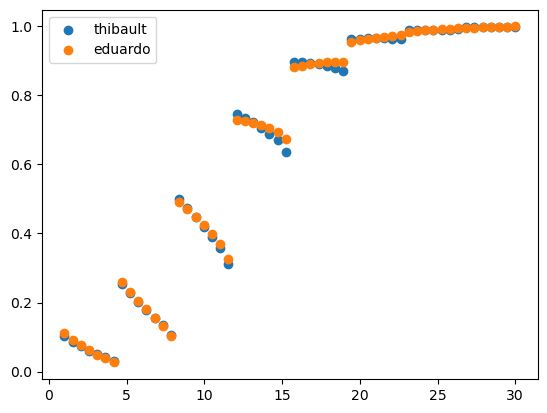

In [14]:
thibault_values_c = []
eduardo_values_c = []
for mbin in mass_bins:
    thibault_values_c.append(f_completeness((np.array(zmean), np.array(mbin)),1.13, 0.77, 13.31, 0.2025))
    eduardo_values_c.append(f_completeness((np.array(zmean), np.array(mbin)),0.3866, 1.26, 13.37, 0.1607))
print(np.array(thibault_values_c).flatten())
print(np.array(eduardo_values_c).flatten())

plt.scatter(np.linspace(1,30, len(np.array(thibault_values_c).flatten())),np.array(thibault_values_c).flatten(), label='thibault')
plt.scatter(np.linspace(1,30, len(np.array(eduardo_values_c).flatten())),np.array(eduardo_values_c).flatten(),label='eduardo')
plt.legend()

In [15]:
## Updating parameters in Notebook

In [16]:
cluster_abundance.update_ingredients(cosmo_ccl)
from firecrown.models.cluster.recipes.murata_binned_spec_z_selection import MurataBinnedSpecZSelectionRecipe as MDS
from firecrown.models.cluster.recipes.murata_binned_spec_z import MurataBinnedSpecZRecipe as MDS2

mds = MDS()

mds.mass_distribution.__setattr__('mu_p0', 3.35)
mds.mass_distribution.__setattr__('mu_p1', 2.23 / np.log(10))
mds.mass_distribution.__setattr__('mu_p2', 0.06)
mds.mass_distribution.__setattr__('sigma_p0', 0.56)
mds.mass_distribution.__setattr__('sigma_p1', 0.10/ np.log(10))
mds.mass_distribution.__setattr__('sigma_p2', -0.05)
mds.completeness_distribution.__setattr__('ac_nc', 0.38)
mds.completeness_distribution.__setattr__('bc_nc', 1.2634)
mds.completeness_distribution.__setattr__('ac_mc', 13.31)
mds.completeness_distribution.__setattr__('bc_mc', 0.2025)
mds.purity_distribution.__setattr__('ap_nc', 2)
mds.purity_distribution.__setattr__('bp_nc', 0.8)
mds.purity_distribution.__setattr__('ap_rc', 0.978)
mds.purity_distribution.__setattr__('bp_rc', -0.2957)
mds.mass_distribution.pivot_mass = np.log(10**14.3) 
mds.mass_distribution.pivot_redshift = 0.5
print(mds.mass_distribution.pivot_mass)
print(np.log(10**14.3) )
print(mds.completeness_distribution.bc_mc)

32.92696682981485
32.92696682981485
0.2025


In [17]:
cluster_abundance.update_ingredients(cosmo_ccl)
mds2 = MDS2()

mds2.mass_distribution.__setattr__('mu_p0', 3.35)
mds2.mass_distribution.__setattr__('mu_p1', 2.23 / np.log(10))
mds2.mass_distribution.__setattr__('mu_p2', 0.06)
mds2.mass_distribution.__setattr__('sigma_p0', 0.56)
mds2.mass_distribution.__setattr__('sigma_p1', 0.10/ np.log(10))
mds2.mass_distribution.__setattr__('sigma_p2', -0.05)
mds2.mass_distribution.pivot_mass = np.log(10**14.3) 
mds2.mass_distribution.pivot_redshift = 0.5
print(mds.mass_distribution.pivot_mass)
print(np.log(10**14.3) )

32.92696682981485
32.92696682981485


In [18]:
mds3 = MDS()

mds3.mass_distribution.__setattr__('mu_p0', 3.35)
mds3.mass_distribution.__setattr__('mu_p1', 2.23 / np.log(10))
mds3.mass_distribution.__setattr__('mu_p2', 0.06)
mds3.mass_distribution.__setattr__('sigma_p0', 0.56)
mds3.mass_distribution.__setattr__('sigma_p1', 0.10/ np.log(10))
mds3.mass_distribution.__setattr__('sigma_p2', -0.05)
mds3.completeness_distribution.__setattr__('ac_nc', 1.1321)
mds3.completeness_distribution.__setattr__('bc_nc', 0.7751)
mds3.completeness_distribution.__setattr__('ac_mc', 13.31)
mds3.completeness_distribution.__setattr__('bc_mc', 0.2025)
mds3.purity_distribution.__setattr__('ap_nc', 0.8612 * np.log(10))
mds3.purity_distribution.__setattr__('bp_nc', 0.3527 * np.log(10))
mds3.purity_distribution.__setattr__('ap_rc', 2.2183)
mds3.purity_distribution.__setattr__('bp_rc', -0.6592)
mds3.mass_distribution.pivot_mass = np.log(10**14.3) 
mds3.mass_distribution.pivot_redshift = 0.5




In [19]:
### Initiating statistic object from firecrown

In [20]:


bin_cl_theory = BinnedClusterNumberCounts(ClusterProperty.COUNTS, survey_nm, mds)
bin_cl_theory.read(s_read)
bin_cl_theory_old = BinnedClusterNumberCounts(ClusterProperty.COUNTS, survey_nm, mds3)
bin_cl_theory_old.read(s_read)
bin_cl_theory_nocp = BinnedClusterNumberCounts(ClusterProperty.COUNTS, survey_nm, mds2)
bin_cl_theory_nocp.read(s_read)




## Computing Counts with Firecrown

In [21]:
from firecrown.modeling_tools import ModelingTools
tools = ModelingTools(cluster_abundance=cluster_abundance)

firecrown_pred = bin_cl_theory.get_binned_cluster_counts(tools)
firecrown_pred = np.array(firecrown_pred)
firecrown_pred_old = bin_cl_theory_old.get_binned_cluster_counts(tools)
firecrown_pred_old = np.array(firecrown_pred_old)
firecrown_pred_nocp = bin_cl_theory_nocp.get_binned_cluster_counts(tools)
firecrown_pred_nocp = np.array(firecrown_pred_nocp) 

[142.42652274  69.33169687  13.0704276    8.54837928 223.40467997
 104.94419931  18.93142208  11.92436837 289.59431269 130.9207197
  22.51197348  13.6083683  332.16957207 144.20936584  23.55460109
  13.62166426 349.00792914 145.26292594  22.46807204  12.39445052
 342.72767966 136.59344373  19.95161861  10.47186361 601.43129158
 224.67824595  30.07079199  14.63365083]
[142, 73, 14, 6, 255, 104, 13, 6, 305, 137, 17, 17, 362, 122, 19, 12, 377, 153, 31, 14, 312, 139, 21, 7, 653, 288, 32, 22]
Dfference between Firecrown and data [ 0.00300368 -0.05025073 -0.06639803  0.42472988 -0.12390322  0.00907884
  0.45626324  0.98739473 -0.05051045 -0.04437431  0.32423373 -0.19950775
 -0.0824045   0.18204398  0.23971585  0.13513869 -0.07424952 -0.05056911
 -0.27522348 -0.11468211  0.09848615 -0.01731335 -0.04992292  0.49598052
 -0.07897199 -0.2198672  -0.06028775 -0.33483405]


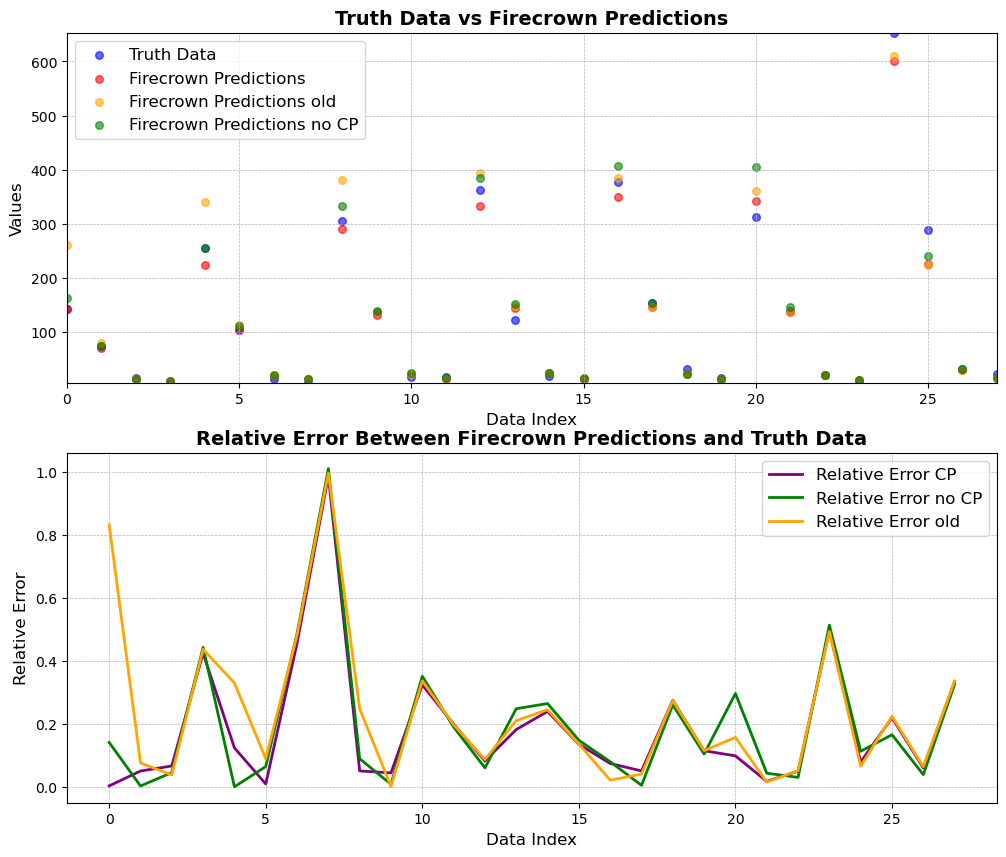

In [22]:
truth_data = [point.value for point in data_points]
print(firecrown_pred)
print(truth_data)


# Compute the difference and relative error
diff_fd = (firecrown_pred - truth_data) / truth_data
print(f"Dfference between Firecrown and data {diff_fd}")
diff_fd_nocp = (firecrown_pred_nocp - truth_data) / truth_data
diff_fd_old = (firecrown_pred_old - truth_data) / truth_data
# Set up the figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 2 rows, 1 column of subplots

# Plotting the first subplot (Truth Data vs Firecrown Predictions)
axs[0].scatter(range(len(truth_data)), truth_data, color='blue', label='Truth Data', s=30, alpha=0.6)
axs[0].scatter(range(len(firecrown_pred)), firecrown_pred, color='red', label='Firecrown Predictions', s=30, alpha=0.6)
axs[0].scatter(range(len(firecrown_pred_old)), firecrown_pred_old, color='orange', label='Firecrown Predictions old', s=30, alpha=0.6)
axs[0].scatter(range(len(firecrown_pred_nocp)), firecrown_pred_nocp, color='green', label='Firecrown Predictions no CP', s=30, alpha=0.6)

# Add title and labels to the first subplot
axs[0].set_title('Truth Data vs Firecrown Predictions', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Data Index', fontsize=12)
axs[0].set_ylabel('Values', fontsize=12)
axs[0].legend(loc='upper left', fontsize=12)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust x and y axis limits with more padding for the first subplot
axs[0].set_xlim([0, len(truth_data)-1])  # Set x axis limit to the length of truth_data
y_min = min(min(truth_data), min(firecrown_pred)) - 0.1
y_max = max(max(truth_data), max(firecrown_pred)) + 0.1
axs[0].set_ylim([y_min, y_max])  # Added padding for the y-axis

# Plotting the second subplot (Relative Error)
axs[1].plot(range(len(diff_fd)), abs(diff_fd), color='purple', label='Relative Error CP', linewidth=2)
axs[1].plot(range(len(diff_fd)), abs(diff_fd_nocp), color='green', label='Relative Error no CP', linewidth=2)
axs[1].plot(range(len(diff_fd_old)), abs(diff_fd_old), color='orange', label='Relative Error old', linewidth=2)
axs[1].set_title('Relative Error Between Firecrown Predictions and Truth Data', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Data Index', fontsize=12)
axs[1].set_ylabel('Relative Error', fontsize=12)
axs[1].legend(loc='upper right', fontsize=12)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)



# Show the plot
plt.savefig('/pbs/home/e/ebarroso/counts_completeness.png')
plt.show()

